In [1]:
import pandas as pd
import numpy as np
import time
import plotly.express as px
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from IPython.display import Image
import statsmodels.formula.api as smf
import warnings
from statsmodels.tools.eval_measures import rmse
%matplotlib inline
warnings.filterwarnings('ignore')

For the team task, we have used a combination of codes developed by the team members Kyle and Reetika individually for the member tasks. Kyle prepared the data for analysis and drew interpretations, while Reetika designed the team task code for plotting the trends and forecast.

In [2]:
data=pd.read_csv("../../../../data/stage_2/owid-covid-data.csv")
#Keeping just the columns we need.
data=data[['location','date','new_cases','new_deaths']]
data

,location,date,new_cases,new_deaths
0,Afghanistan,2020-02-24,5.0,NaN
1,Afghanistan,2020-02-25,0.0,NaN
2,Afghanistan,2020-02-26,0.0,NaN
3,Afghanistan,2020-02-27,0.0,NaN
4,Afghanistan,2020-02-28,0.0,NaN
...,...,...,...,...
164249,Zimbabwe,2022-02-20,128.0,0.0
164250,Zimbabwe,2022-02-21,219.0,0.0
164251,Zimbabwe,2022-02-22,409.0,2.0
164252,Zimbabwe,2022-02-23,609.0,0.0


The code below was used to keep the dates between 03-21-2020 and 02-05-2022, just like we did in the Stage 2 Team Task. 

In [3]:
data1 = data[~(data['date'] < '2020-03-21')]
data2 = data1[~(data1['date'] > '2022-02-05')]

We now need to separate the USA into its own datest, and then set any NaNs as 0. 

In [4]:
USA=data2[data2.location=='United States'].reset_index(drop=True)
USA.new_cases=USA.new_cases.fillna(0)
USA.new_deaths=USA.new_deaths.fillna(0)
USA

,location,date,new_cases,new_deaths
0,United States,2020-03-21,5995.0,103.0
1,United States,2020-03-22,8919.0,128.0
2,United States,2020-03-23,11152.0,187.0
3,United States,2020-03-24,10618.0,243.0
4,United States,2020-03-25,12127.0,333.0
...,...,...,...,...
682,United States,2022-02-01,414544.0,3705.0
683,United States,2022-02-02,327163.0,3622.0
684,United States,2022-02-03,253357.0,2302.0
685,United States,2022-02-04,371155.0,4204.0


The array below is needed for our linear model function. 

In [5]:
x=USA.index.values
x

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

This function allows us to generate linear and non-linear model trends for our USA COVID dataset. The parameters needed for the function to work are x (the array generated above), y (the column in our dataset that contains cases or deaths), and df (our USA dataframe).

In [6]:
def model(x,y,df):    
   
    X = pd.DataFrame({'x': x})
    n = len(x)
    max_x = max(x)
    x_new = pd.DataFrame({'x':np.arange(max_x+1, max_x+8)})
    ## linear model (of degree 1)
    print('Linear model (degree=1)\n')
    m_1 = smf.ols(formula='y ~ x', data=df).fit()
    print('The coefficient estimates are:\n', m_1.params)
     
    rmse_1 = rmse(y, m_1.predict(X))
    print('RMSE = ',rmse_1)
   
    #predicting next 7 day counts
    pred_1 = m_1.predict(x_new)
       
    c1 = m_1.predict(X).copy(deep = True)
    c2 = pred_1.copy(deep = True)
    p1 = pd.concat([c1, c2], ignore_index=True, sort=False) #predicted and forecasted counts for linear model

    ## nonlinear model (of degree 2)
    print('Nonlinear model (degree=2)\n')
    m_2 = smf.ols(formula='y ~ x + I(x ** 2.0)', data=df).fit()
    print('The coefficient estimates are:\n', m_2.params)
     
    rmse_2 = rmse(y, m_2.predict(X))
    print('RMSE = ',rmse_2)
   
    #predicting next 7 day counts
    pred_2 = m_2.predict(x_new)
       
    c1 = m_2.predict(X).copy(deep = True)
    c2 = pred_2.copy(deep = True)
    p2 = pd.concat([c1, c2], ignore_index=True, sort=False) #predicted and forecasted counts for nonlinear model of degree 2
     
    ## nonlinear model (of degree 3)
    print('Nonlinear model (degree=3)\n')
    m_3 = smf.ols(formula='y ~ x + I(x ** 2.0) + I(x ** 3.0)', data=df).fit()
    print('The coefficient estimates are:\n', m_3.params)
     
    rmse_3 = rmse(y, m_3.predict(X))
    print('RMSE = ',rmse_3)
   
    #predicting next 7 day counts
    pred_3 = m_3.predict(x_new)
       
    c1 = m_3.predict(X).copy(deep = True)
    c2 = pred_3.copy(deep = True)
    p3 = pd.concat([c1, c2], ignore_index=True, sort=False) #predicted and forecasted counts for nonlinear model of degree 3
   
    ## plots of all the three models and the predicted counts
    #splitting plot into two parts: Fitted plot and Predicted plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8*1.618, 8))
   
    #scatter plot of points
    ax1.scatter(x,y, color='0.8', label='Values')

    #fitted values for linear model
    sns.regplot(x=p1[:n-1].index, y=p1[:n-1].values, data=p1, order=1, color='black', scatter=False,
                ax=ax1, label='Linear Model (degree=1)')
    ax2.plot(p1[n:].index, p1[n:].values, 'kx', label='Linear Model (degree=1)')
   
    #fitted values for nonlinear model (degree=2)
    sns.regplot(x=p2[:n-1].index, y=p2[:n-1].values, data=p2, order=2, color='green', scatter=False,
                ax=ax1, label='NonLinear Model (degree=2)')
    ax2.plot(p2[n:].index, p2[n:].values, 'gx', label='NonLinear Model (degree=2)')
   
    #fitted values for nonlinear model (degree=3)
    sns.regplot(x=p3[:n-1].index, y=p3[:n-1].values, data=p3, order=3, color='red', scatter=False,
                ax=ax1, label='NonLinear Model (degree=3)')
    ax2.plot(p3[n:].index, p3[n:].values, 'rx', label='NonLinear Model (degree=3)')
   
    ax1.legend()
    ax2.legend()
   
    ax1.title.set_text('Fitted values')
    ax2.title.set_text('Predicted values')
   
    plt.show()

Now let's implement the function for the US. 

Linear model (degree=1)

The coefficient estimates are:
 Intercept   -1692.919472
x             329.300252
dtype: float64
RMSE =  138225.92702135353
Nonlinear model (degree=2)

The coefficient estimates are:
 Intercept      89158.488523
x               -466.478504
I(x ** 2.0)        1.160027
dtype: float64
RMSE =  132064.87281581547
Nonlinear model (degree=3)

The coefficient estimates are:
 Intercept     -88522.820926
x               2653.015002
I(x ** 2.0)      -10.216673
I(x ** 3.0)        0.011056
dtype: float64
RMSE =  113364.75114669211


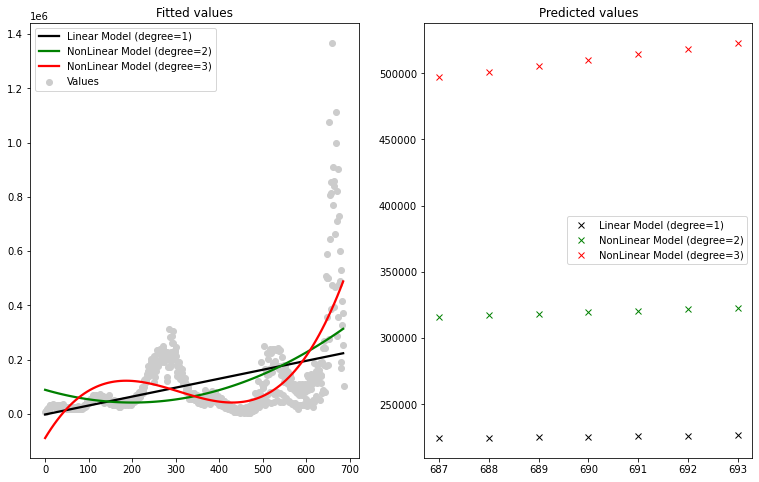

In [7]:
model(x,USA.new_cases,USA)

As we can see, it appears that the NonLinear Model with 3 degrees best models our COVID cases in the United States, as it accounts for the relevant peaks and valleys in COVID cases. This can further be confirmed by analyzing the Root Mean Square Error (RMSE) for the 3 models. 

In regression, RMSE is a function of both bias and variance, and both are forms of error. Bias is the extent to which the model makes incorrect assumptions regarding the data, and can cause the resulting model to underfit the data. Variance is how much the model reacts to small changes in the data, and can cause the resulting model to overfit the data. Bias and Variance are inversely related; as one decreases, the other increases. Linear models are considered high Bias and low Variance, while non-linear models decrease in Bias and increase in Variance as their complexity rises. The decision as to which model to use based on Bias and Variance is the Bias-Variance tradeoff. 

RMSE is calculated using both errors, and decreases with increased model complexity. For this task, our decision as to which model is best will be based on how much RMSE decreases as the model increases in complexity. For example, we can see here with the US COVID cases that the linear model and the nonlinear model with two degrees have similar RMSE, indicating that they're equally as useful models for the data. In contrast, the nonlinear model with three degress has a much lower RMSE. This confirms our initial belief that model 3 best models our USA COVID cases. We can check to see if this is true for the deaths. 

Linear model (degree=1)

The coefficient estimates are:
 Intercept    1204.738436
x               0.322748
dtype: float64
RMSE =  961.2797804062981
Nonlinear model (degree=2)

The coefficient estimates are:
 Intercept      1312.983042
x                -0.625380
I(x ** 2.0)       0.001382
dtype: float64
RMSE =  960.0494161239312
Nonlinear model (degree=3)

The coefficient estimates are:
 Intercept      787.255461
x                8.604650
I(x ** 2.0)     -0.032280
I(x ** 3.0)      0.000033
dtype: float64
RMSE =  938.8902633170445


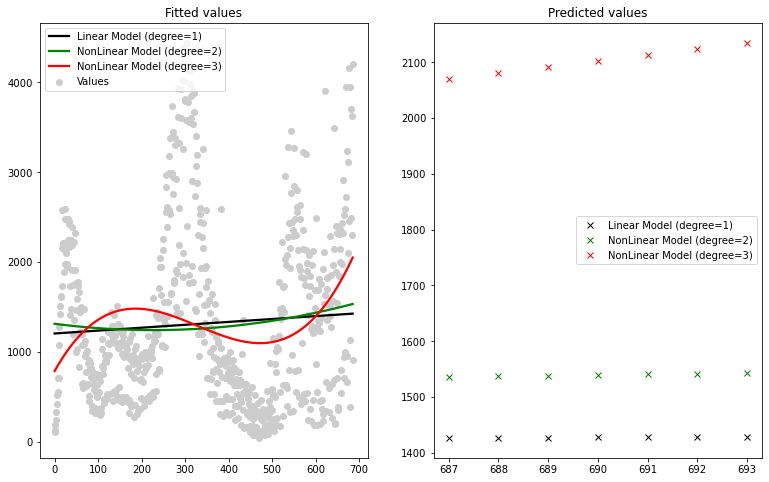

In [8]:
model(x,USA.new_deaths,USA)

Unlike like with COVID cases, RMSE does not decrease much in either of the nonlinear models. This would indicate that we should use the linear model, to limit the impact of small fluctuations in the data. 

Our next task is to compare the US trends with the trends from other countries. Let's start with Brazil.

In [9]:
Brazil=data2[data2.location=='Brazil'].reset_index(drop=True)
Brazil.new_cases=Brazil.new_cases.fillna(0)
Brazil.new_deaths=Brazil.new_deaths.fillna(0)
Brazil

,location,date,new_cases,new_deaths
0,Brazil,2020-03-21,228.0,4.0
1,Brazil,2020-03-22,525.0,10.0
2,Brazil,2020-03-23,378.0,9.0
3,Brazil,2020-03-24,323.0,12.0
4,Brazil,2020-03-25,307.0,13.0
...,...,...,...,...
682,Brazil,2022-02-01,171251.0,767.0
683,Brazil,2022-02-02,185964.0,945.0
684,Brazil,2022-02-03,287149.0,1000.0
685,Brazil,2022-02-04,218560.0,964.0


Linear model (degree=1)

The coefficient estimates are:
 Intercept    24032.543520
x               41.794584
dtype: float64
RMSE =  33957.96628318348
Nonlinear model (degree=2)

The coefficient estimates are:
 Intercept      11277.946017
x                153.513686
I(x ** 2.0)       -0.162856
dtype: float64
RMSE =  33471.21331427772
Nonlinear model (degree=3)

The coefficient estimates are:
 Intercept     -16455.048872
x                640.412943
I(x ** 2.0)       -1.938563
I(x ** 3.0)        0.001726
dtype: float64
RMSE =  31757.07653789185


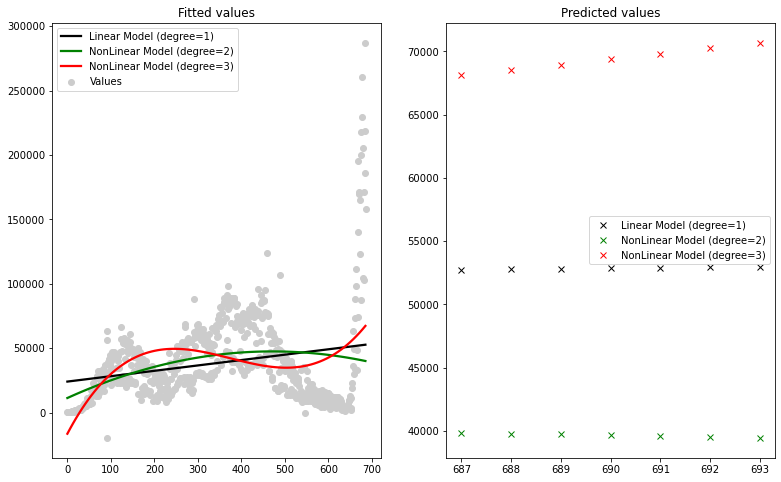

In [10]:
model(x,Brazil.new_cases,Brazil)

Regarding COVID cases, Brazil appears to have a flatter curve than the US, and its nonlinear model with 2 degrees is actually showing a downward curve to the data, as opposed to US's upward curve for all models. How about deaths?

Linear model (degree=1)

The coefficient estimates are:
 Intercept    941.352929
x             -0.062067
dtype: float64
RMSE =  772.4935786070101
Nonlinear model (degree=2)

The coefficient estimates are:
 Intercept     -0.364630
x              8.186554
I(x ** 2.0)   -0.012024
dtype: float64
RMSE =  646.3931450419519
Nonlinear model (degree=3)

The coefficient estimates are:
 Intercept      369.119364
x                1.699643
I(x ** 2.0)      0.011633
I(x ** 3.0)     -0.000023
dtype: float64
RMSE =  630.8548287154752


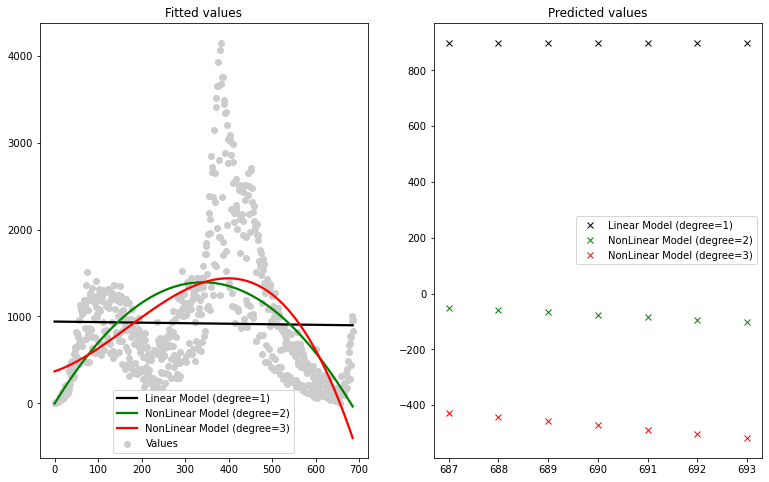

In [11]:
model(x,Brazil.new_deaths,Brazil)

Brazil differs even more with COVID deaths. All 3 models predict a downward trend in COVID deaths, while US predicts an upward trend with all models. Our next comparison is with the Democratic Republic of Congo.

In [12]:
Congo=data2[data2.location=='Democratic Republic of Congo'].reset_index(drop=True)
Congo.new_cases=Congo.new_cases.fillna(0)
Congo.new_deaths=Congo.new_deaths.fillna(0)
Congo

,location,date,new_cases,new_deaths
0,Democratic Republic of Congo,2020-03-21,5.0,1.0
1,Democratic Republic of Congo,2020-03-22,7.0,0.0
2,Democratic Republic of Congo,2020-03-23,6.0,0.0
3,Democratic Republic of Congo,2020-03-24,9.0,1.0
4,Democratic Republic of Congo,2020-03-25,3.0,0.0
...,...,...,...,...
682,Democratic Republic of Congo,2022-02-01,0.0,0.0
683,Democratic Republic of Congo,2022-02-02,131.0,0.0
684,Democratic Republic of Congo,2022-02-03,0.0,0.0
685,Democratic Republic of Congo,2022-02-04,0.0,0.0


Linear model (degree=1)

The coefficient estimates are:
 Intercept    11.368382
x             0.329662
dtype: float64
RMSE =  293.3626379851208
Nonlinear model (degree=2)

The coefficient estimates are:
 Intercept      59.264599
x              -0.089867
I(x ** 2.0)     0.000612
dtype: float64
RMSE =  292.57273151514363
Nonlinear model (degree=3)

The coefficient estimates are:
 Intercept      20.025315
x               0.599045
I(x ** 2.0)    -0.001901
I(x ** 3.0)     0.000002
dtype: float64
RMSE =  292.18995047038794


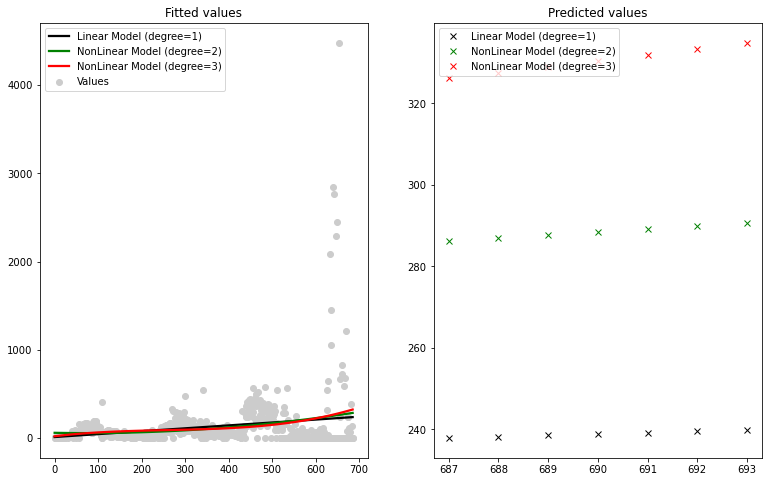

In [13]:
model(x,Congo.new_cases,Congo)

Here we can see that all 3 models are incredibly similar, and do not match the US data models. It appears that Congo has been relatively consistent with COVID cases throughout the pandemic, as opposed to the peaks and valleys we see in the US. 

Linear model (degree=1)

The coefficient estimates are:
 Intercept    1.795395
x            0.000189
dtype: float64
RMSE =  8.702391275701478
Nonlinear model (degree=2)

The coefficient estimates are:
 Intercept      1.118089
x              0.006122
I(x ** 2.0)   -0.000009
dtype: float64
RMSE =  8.697071948281526
Nonlinear model (degree=3)

The coefficient estimates are:
 Intercept      4.353941e-01
x              1.810757e-02
I(x ** 2.0)   -5.236015e-05
I(x ** 3.0)    4.248012e-08
dtype: float64
RMSE =  8.693175802862353


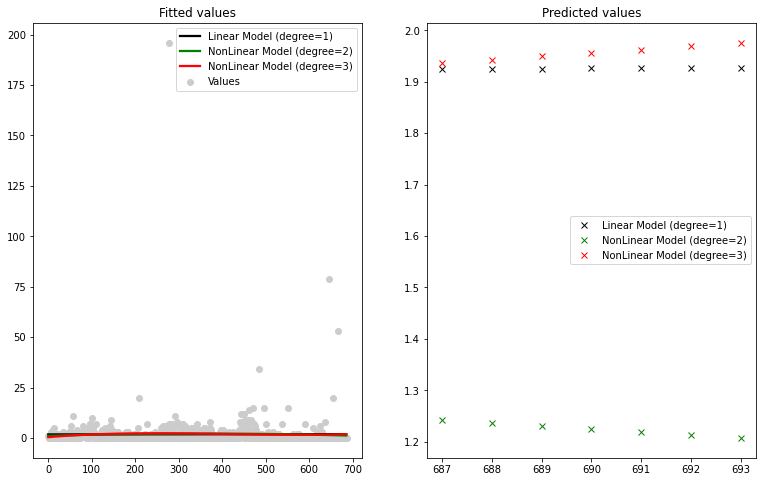

In [14]:
model(x,Congo.new_deaths,Congo)

For deaths, this flat trend continues, and is even more pronounced than with the cases. All 3 models seem to be equivalent, to the point that both nonlinear models are nearly linear themselves. Next is Iran.

In [15]:
Iran=data2[data2.location=='Iran'].reset_index(drop=True)
Iran.new_cases=Iran.new_cases.fillna(0)
Iran.new_deaths=Iran.new_deaths.fillna(0)
Iran

,location,date,new_cases,new_deaths
0,Iran,2020-03-21,966.0,123.0
1,Iran,2020-03-22,1028.0,129.0
2,Iran,2020-03-23,1411.0,127.0
3,Iran,2020-03-24,1762.0,122.0
4,Iran,2020-03-25,2206.0,143.0
...,...,...,...,...
682,Iran,2022-02-01,35070.0,50.0
683,Iran,2022-02-02,38160.0,59.0
684,Iran,2022-02-03,37395.0,61.0
685,Iran,2022-02-04,36908.0,57.0


Linear model (degree=1)

The coefficient estimates are:
 Intercept    2193.424114
x              21.292180
dtype: float64
RMSE =  8101.867852814268
Nonlinear model (degree=2)

The coefficient estimates are:
 Intercept     -4117.784304
x                76.572838
I(x ** 2.0)      -0.080584
dtype: float64
RMSE =  7589.73735374165
Nonlinear model (degree=3)

The coefficient estimates are:
 Intercept      4134.488092
x               -68.309650
I(x ** 2.0)       0.447798
I(x ** 3.0)      -0.000513
dtype: float64
RMSE =  6906.8166914212525


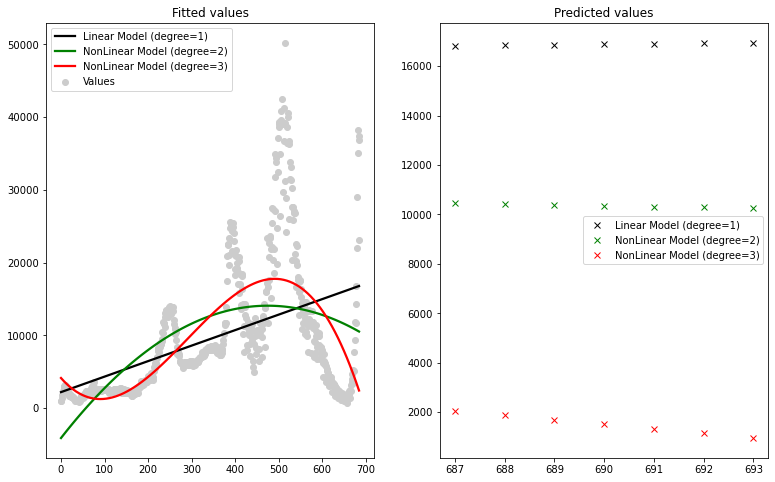

In [16]:
model(x,Iran.new_cases,Iran)

For the nonlinear models of COVID cases, Iran peaks later than the US, and is now currently in a downward trend. Their linear models are similar, however. 

Linear model (degree=1)

The coefficient estimates are:
 Intercept    164.810683
x              0.076757
dtype: float64
RMSE =  144.02489201285766
Nonlinear model (degree=2)

The coefficient estimates are:
 Intercept      44.175796
x               1.133413
I(x ** 2.0)    -0.001540
dtype: float64
RMSE =  133.4431837587555
Nonlinear model (degree=3)

The coefficient estimates are:
 Intercept      124.919365
x               -0.284176
I(x ** 2.0)      0.003630
I(x ** 3.0)     -0.000005
dtype: float64
RMSE =  129.8434112794292


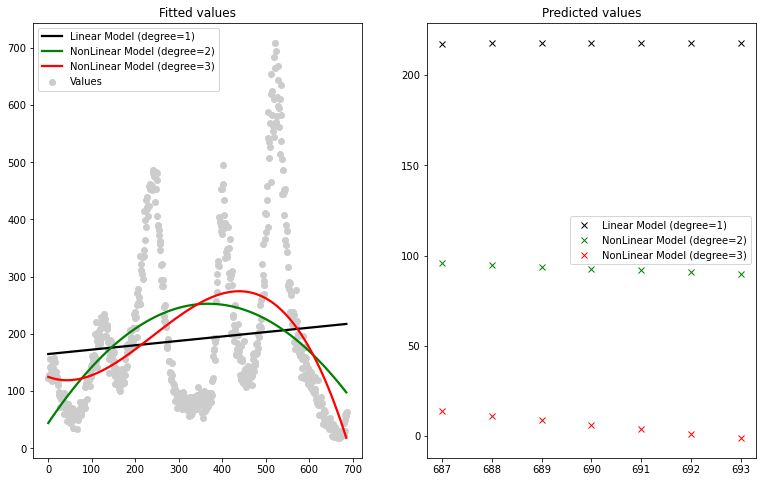

In [17]:
model(x,Iran.new_deaths,Iran)

The deaths for Iran have quite similar trends to the new cases, and again differ in their nonlinear models by having a later peak and a downward trend at the end. Next we move on to Mexico.

In [18]:
Mexico=data2[data2.location=='Mexico'].reset_index(drop=True)
Mexico.new_cases=Mexico.new_cases.fillna(0)
Mexico.new_deaths=Mexico.new_deaths.fillna(0)
Mexico

,location,date,new_cases,new_deaths
0,Mexico,2020-03-21,48.0,0.0
1,Mexico,2020-03-22,65.0,1.0
2,Mexico,2020-03-23,51.0,1.0
3,Mexico,2020-03-24,38.0,1.0
4,Mexico,2020-03-25,70.0,1.0
...,...,...,...,...
682,Mexico,2022-02-01,43099.0,829.0
683,Mexico,2022-02-02,0.0,0.0
684,Mexico,2022-02-03,42181.0,573.0
685,Mexico,2022-02-04,78178.0,1336.0


Linear model (degree=1)

The coefficient estimates are:
 Intercept    2027.041751
x              15.907717
dtype: float64
RMSE =  10074.927308809667
Nonlinear model (degree=2)

The coefficient estimates are:
 Intercept      4308.105792
x                -4.072406
I(x ** 2.0)       0.029126
dtype: float64
RMSE =  10022.693309245804
Nonlinear model (degree=3)

The coefficient estimates are:
 Intercept     -3662.041877
x               135.856909
I(x ** 2.0)      -0.481193
I(x ** 3.0)       0.000496
dtype: float64
RMSE =  9550.901870501106


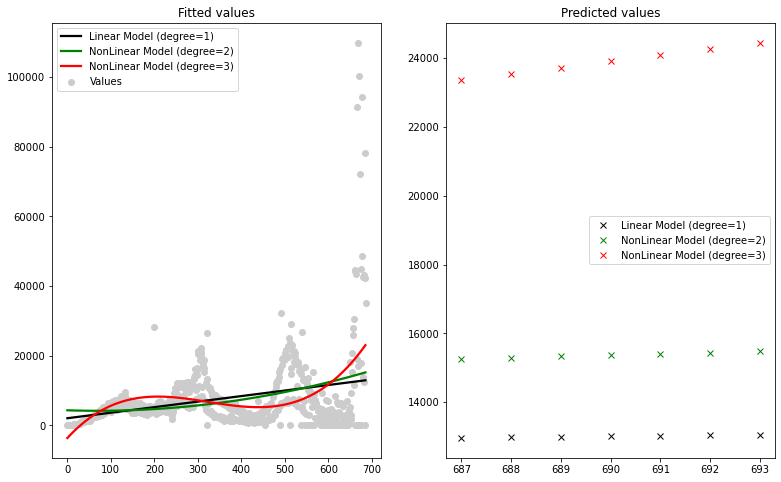

In [19]:
model(x,Mexico.new_cases,Mexico)

Mexico's COVID cases have similar trends in terms of when they peak and valley to the US, but are flatter. 

Linear model (degree=1)

The coefficient estimates are:
 Intercept    509.175087
x             -0.189527
dtype: float64
RMSE =  370.1365385667412
Nonlinear model (degree=2)

The coefficient estimates are:
 Intercept      202.989701
x                2.492389
I(x ** 2.0)     -0.003909
dtype: float64
RMSE =  343.6374353940723
Nonlinear model (degree=3)

The coefficient estimates are:
 Intercept     -14.383945
x               6.308748
I(x ** 2.0)    -0.017828
I(x ** 3.0)     0.000014
dtype: float64
RMSE =  333.4929647193


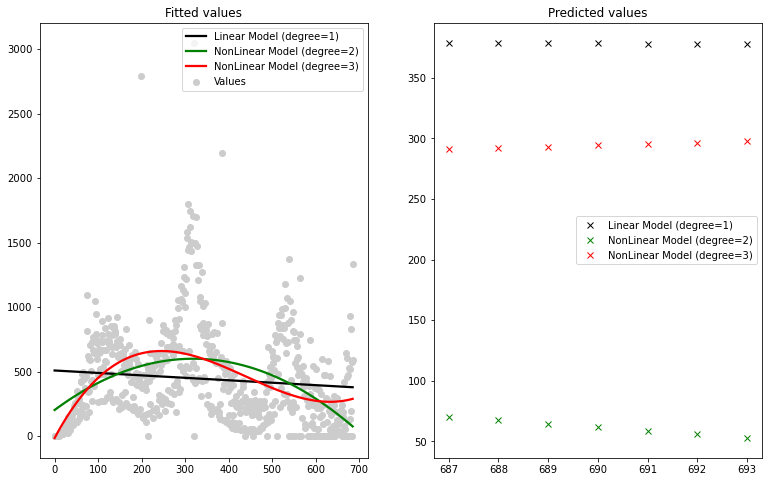

In [20]:
model(x,Mexico.new_deaths,Mexico)

By contrast, deaths differ from the US quite a bit. Both the linear and nonlinear with 2 degrees predict a downward trend, versus the US' upward trend for all 3 models. We now look at Myanmar. 

In [21]:
Myanmar=data2[data2.location=='Myanmar'].reset_index(drop=True)
Myanmar.new_cases=Myanmar.new_cases.fillna(0)
Myanmar.new_deaths=Myanmar.new_deaths.fillna(0)
x2=Myanmar.index.values
Myanmar

,location,date,new_cases,new_deaths
0,Myanmar,2020-03-27,8.0,0.0
1,Myanmar,2020-03-28,0.0,0.0
2,Myanmar,2020-03-29,2.0,0.0
3,Myanmar,2020-03-30,4.0,0.0
4,Myanmar,2020-03-31,1.0,1.0
...,...,...,...,...
676,Myanmar,2022-02-01,861.0,0.0
677,Myanmar,2022-02-02,143.0,0.0
678,Myanmar,2022-02-03,368.0,0.0
679,Myanmar,2022-02-04,319.0,0.0


Linear model (degree=1)

The coefficient estimates are:
 Intercept    93.332196
x             2.047205
dtype: float64
RMSE =  1144.431447976408
Nonlinear model (degree=2)

The coefficient estimates are:
 Intercept     -488.138676
x                7.185386
I(x ** 2.0)     -0.007556
dtype: float64
RMSE =  1114.2276449519572
Nonlinear model (degree=3)

The coefficient estimates are:
 Intercept      421.839659
x               -8.932297
I(x ** 2.0)      0.051744
I(x ** 3.0)     -0.000058
dtype: float64
RMSE =  1058.8228900041981


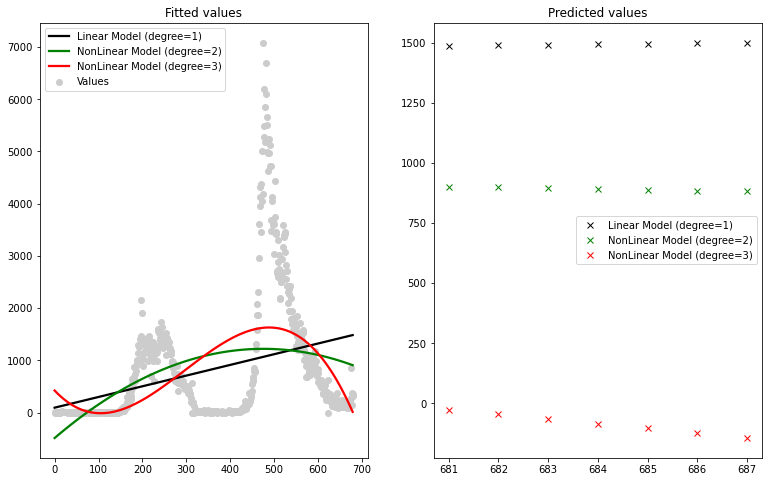

In [22]:
model(x2,Myanmar.new_cases,Myanmar)

Myanmar predicts a downward trend in cases in both nonlinear models, versus the US' upward trends. Myanmar has already hit its peak with those 2 models, while the US is currently experiencing its peak.

Linear model (degree=1)

The coefficient estimates are:
 Intercept   -2.205455
x            0.089885
dtype: float64
RMSE =  62.191815820146516
Nonlinear model (degree=2)

The coefficient estimates are:
 Intercept     -24.719655
x               0.288832
I(x ** 2.0)    -0.000293
dtype: float64
RMSE =  61.364052775506146
Nonlinear model (degree=3)

The coefficient estimates are:
 Intercept      29.882290
x              -0.678286
I(x ** 2.0)     0.003266
I(x ** 3.0)    -0.000003
dtype: float64
RMSE =  57.724042350028135


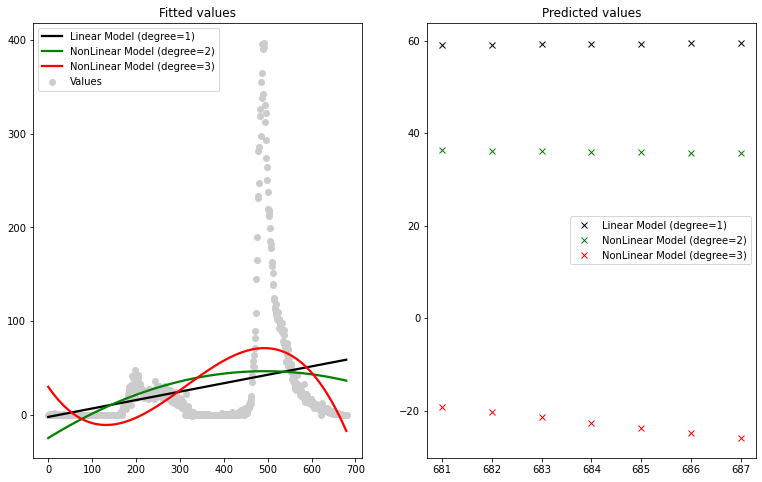

In [23]:
model(x2,Myanmar.new_deaths,Myanmar)

The deaths are nearly identical in overall trend to the cases, and differ from the US in the same ways. Next we have South Africa. 

In [24]:
South_Africa=data2[data2.location=='South Africa'].reset_index(drop=True)
South_Africa.new_cases=South_Africa.new_cases.fillna(0)
South_Africa.new_deaths=South_Africa.new_deaths.fillna(0)
South_Africa

,location,date,new_cases,new_deaths
0,South Africa,2020-03-21,38.0,0.0
1,South Africa,2020-03-22,34.0,0.0
2,South Africa,2020-03-23,128.0,0.0
3,South Africa,2020-03-24,152.0,0.0
4,South Africa,2020-03-25,155.0,0.0
...,...,...,...,...
682,South Africa,2022-02-01,3085.0,195.0
683,South Africa,2022-02-02,4502.0,175.0
684,South Africa,2022-02-03,3266.0,82.0
685,South Africa,2022-02-04,0.0,0.0


Linear model (degree=1)

The coefficient estimates are:
 Intercept    2773.466136
x               7.206092
dtype: float64
RMSE =  5562.835203607567
Nonlinear model (degree=2)

The coefficient estimates are:
 Intercept      1467.956574
x                18.641212
I(x ** 2.0)      -0.016669
dtype: float64
RMSE =  5531.841861015835
Nonlinear model (degree=3)

The coefficient estimates are:
 Intercept      1069.855016
x                25.630553
I(x ** 2.0)      -0.042159
I(x ** 3.0)       0.000025
dtype: float64
RMSE =  5529.75901246469


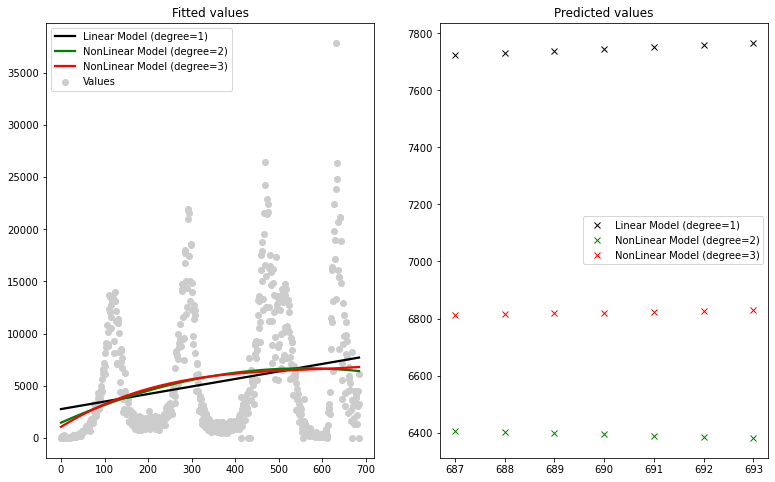

In [25]:
model(x,South_Africa.new_cases,South_Africa)

Similar to Congo, COVID cases appear relatively consistent based on the predicted trends of the 3 models, versus the US having more distinct peaks and valleys. 

Linear model (degree=1)

The coefficient estimates are:
 Intercept    112.541544
x              0.076175
dtype: float64
RMSE =  147.06137423391536
Nonlinear model (degree=2)

The coefficient estimates are:
 Intercept     -13.480383
x               1.180017
I(x ** 2.0)    -0.001609
dtype: float64
RMSE =  135.73091169746723
Nonlinear model (degree=3)

The coefficient estimates are:
 Intercept     -2.158012e+01
x              1.322221e+00
I(x ** 2.0)   -2.127714e-03
I(x ** 3.0)    5.039995e-07
dtype: float64
RMSE =  135.6957736820182


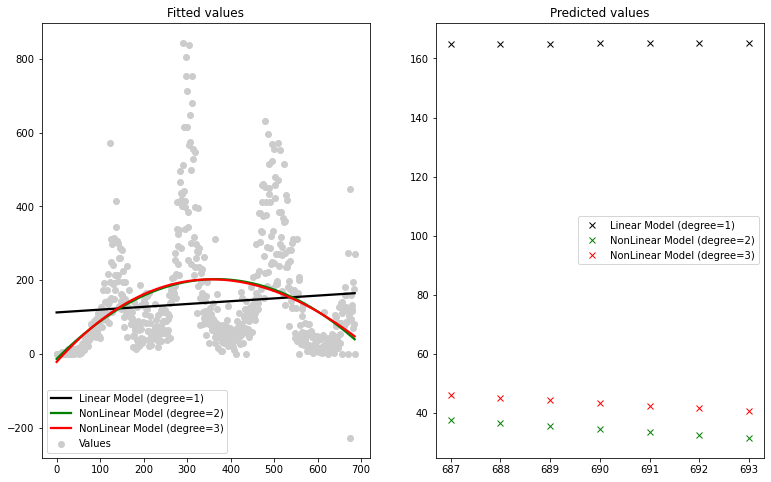

In [26]:
model(x,South_Africa.new_deaths,South_Africa)

By contrast, the 2 nonlinear models for deaths have a more pronounced curve. Unlike the US, they appear to almost follow a normal bell curve, now trending downward. Lastly, let's look at Spain. 

In [27]:
Spain=data2[data2.location=='Spain'].reset_index(drop=True)
Spain.new_cases=Spain.new_cases.fillna(0)
Spain.new_deaths=Spain.new_deaths.fillna(0)
Spain

,location,date,new_cases,new_deaths
0,Spain,2020-03-21,4964.0,332.0
1,Spain,2020-03-22,3394.0,397.0
2,Spain,2020-03-23,6368.0,539.0
3,Spain,2020-03-24,4749.0,497.0
4,Spain,2020-03-25,9630.0,839.0
...,...,...,...,...
682,Spain,2022-02-01,77873.0,408.0
683,Spain,2022-02-02,86222.0,224.0
684,Spain,2022-02-03,74368.0,183.0
685,Spain,2022-02-04,0.0,0.0


Linear model (degree=1)

The coefficient estimates are:
 Intercept   -4773.674139
x              57.115783
dtype: float64
RMSE =  34877.805052258715
Nonlinear model (degree=2)

The coefficient estimates are:
 Intercept      14605.728104
x               -112.630806
I(x ** 2.0)        0.247444
dtype: float64
RMSE =  33774.10490972352
Nonlinear model (degree=3)

The coefficient estimates are:
 Intercept     -16302.892310
x                430.021884
I(x ** 2.0)       -1.731594
I(x ** 3.0)        0.001923
dtype: float64
RMSE =  31651.3471764719


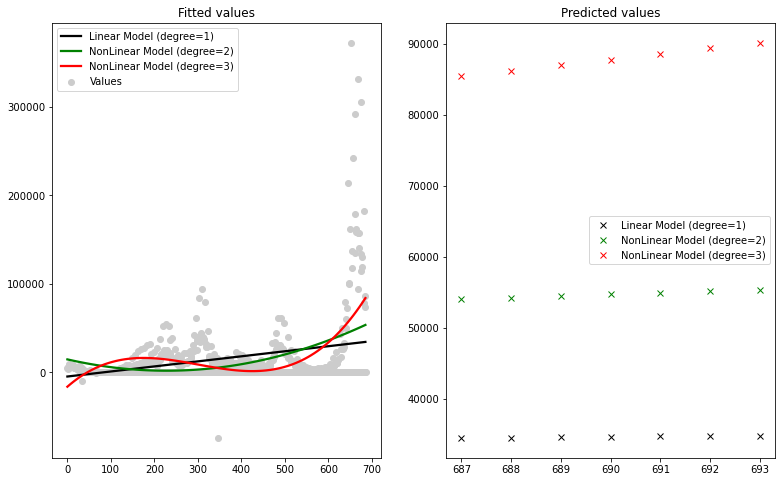

In [28]:
model(x,Spain.new_cases,Spain)

COVID cases for Spain have a nearly identical trend to the US for the 2 nonlinear models, though the trend is flatter in nature. 

Linear model (degree=1)

The coefficient estimates are:
 Intercept    236.244859
x             -0.294105
dtype: float64
RMSE =  211.82323634534742
Nonlinear model (degree=2)

The coefficient estimates are:
 Intercept      272.065574
x               -0.607863
I(x ** 2.0)      0.000457
dtype: float64
RMSE =  211.21128672017159
Nonlinear model (degree=3)

The coefficient estimates are:
 Intercept      349.737725
x               -1.971528
I(x ** 2.0)      0.005431
I(x ** 3.0)     -0.000005
dtype: float64
RMSE =  209.12476966412407


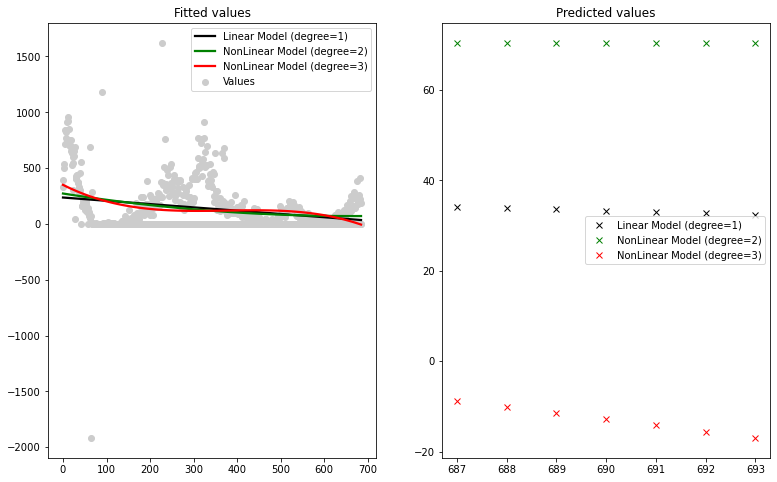

In [29]:
model(x,Spain.new_deaths,Spain)

Deaths show a different picture. Of all the countries we looked at, Spain has the most consistent downward curve as the days since first infection increase. It and Myanmar are the only two countries with an overall downward trend in the linear model.

Please refer to Member Task Notebooks for the Member Task portion of Stage 4. 